# Refining posterior estimates with importance sampling

# Theory

SBI estimates the posterior $p(\theta|x) = {p(\theta)p(x|\theta)}/{p(x)}$ based on samples from the prior $\theta\sim p(\theta)$ and the likelihood $x\sim p(x|\theta)$. Sometimes, we can do both, *sample* and *evaluate* the prior and likelihood. In this case, we can combine the *simulation-based* estimate $q(\theta|x)$ with *likelihood-based* importance sampling, and thereby generate an asymptotically exact estimate for $p(\theta|x)$.

### Importance weights

The main idea is to interpret $q(\theta|x)$ as a proposal distribution and generate proposal samples $\theta_i\sim q(\theta|x)$, and then augment each sample with an importance weight $w_i = p(\theta_i|x) / q(\theta_i|x)$. The definition of the importance weights is motivated from Monte Carlo estimates for the random variable $f(\theta)$, 

$$ 
\mathbb{E}_{\theta\sim p(\theta|x)}\left[f(\theta)\right] 
=\int p(\theta|x) f(\theta)\,\text{d}\theta
\approx \sum_{\theta_i\sim p(\theta_i|x)} f(\theta_i).
$$

We can rewrite this expression as 

$$ 
\mathbb{E}_{\theta\sim p(\theta|x)}\left[f(\theta)\right] 
=\int p(\theta|x) f(\theta)\,\text{d}\theta
=\int q(\theta|x) \frac{p(\theta|x)}{q(\theta|x)}f(\theta)\,\text{d}\theta
\approx \sum_{\theta_i\sim q(\theta_i|x)} \frac{p(\theta_i|x)}{q(\theta_i|x)}f(\theta_i)
\approx \sum_{\theta_i\sim q(\theta_i|x)} w_i\cdot f(\theta_i).
$$

Instead of sampling $\theta_i\sim p(\theta_i|x)$, we can thus sample $\theta_i\sim q(\theta_i|x)$ and attach a corresponding importance weight $w_i$ to each sample. Intuitively, the importance weights downweight samples where $q(\theta|x)$ overestimates $p(\theta|x)$ and upweight samples where $p(\theta|x)$ underestimates $q(\theta|x)$.

### Effective sample size $n_\text{eff}$ and sample efficiency $\epsilon$

If inference were perfect, we would have $w_i = p(\theta_i|x) / q(\theta_i|x) = 1~\forall i$. In practice however, SBI does not provide exact inference results $q(\theta_i|x)$, and the weights will have a finite variance $\text{Var}(w) > 0$. Performing the Monte Carlo estimate above with $n$ samples from $q(\theta|x)$ thus results in reduced precision compared to doing the same with $n$ samples from $p(\theta|x)$. This is formalized by the notion of the *effective sample size* (see e.g. [here](http://www2.stat.duke.edu/~scs/Courses/Stat376/Papers/ConvergeRates/LiuMetropolized1996.pdf))

$$
n_\text{eff} = \frac{n}{1 + \text{Var}(w)} = \frac{\left(\sum_i w_i\right)^2}{\sum_i \left(w_i^2\right)}.
$$

Loosely speaking, using $n$ samples $\theta_i\sim q(\theta_i|x)$ is equivalent to using $n_\text{eff}$ samples from the true posterior $p(\theta|x)$. The *sample efficiency*

$$
\epsilon = \frac{n_\text{eff}}{n} \in (0, 1]
$$

is an indirect measure of the quality of the proposal $q(\theta|x)$.

### Mass coverage
Importance sampling requires $p(\theta|x) \subseteq q(\theta|x)$. When using NPE, this should naturally be ensured, as NPE is trained with the mass-covering forward KL divergence, such that $p(\theta|x) \not\subseteq q(\theta|x)$ for in-distribution data would imply a diverging validation loss. 

When $q(\theta|x)$ is a light-tailed estimate of $p(\theta|x)$, the variance of the importance weights is unbounded and we may encounter a small sample efficiency $\epsilon$.

### Self-normalized importance sampling and the Bayesian evidence

In practice, we don't have access to the normalized posterior, but only to $p(\theta|x) \cdot p(x) = p(\theta)p(x|\theta)$. We thus have to use self-normalized importance sampling. In this case, an unbiased estimate of the Bayesian evidence $p(x)$ can be computed from the normalization of the importance weights (see e.g. [here](https://arxiv.org/abs/2210.05686))

$$
p(x) = \frac{\sum_i w_i}{n}
$$

with a statistical uncertainty scaling with $1/\sqrt{n}$,

$$
\sigma_{p(x)} = p(x)\cdot \sqrt{\frac{1-\epsilon}{n\cdot \epsilon}}.
$$

# Implementation

In [1]:
from torch import ones, eye
import torch
from torch.distributions import MultivariateNormal
import matplotlib.pyplot as plt

from sbi.inference import SNPE, ImportanceSamplingPosterior
from sbi.utils import BoxUniform
from sbi.inference.potentials.base_potential import BasePotential
from sbi.analysis import marginal_plot

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


We first define a simulator and a prior which both have functions for sampling (as required for SBI) and log_prob evaluations (as required for importance sampling).

Next we train an NPE model for inference.

Now we perfrom inference with the model.

In [2]:
# define prior and simulator
class Simulator:
    def __init__(self):
        pass

    def log_likelihood(self, theta, x):
        return MultivariateNormal(theta, eye(2)).log_prob(x)

    def sample(self, theta):
        return theta + torch.randn((theta.shape))

prior = BoxUniform(-5 * ones((2,)), 5 * ones((2,)))
sim = Simulator()
log_prob_fn = lambda theta, x_o: sim.log_likelihood(theta, x_o) + prior.log_prob(theta)

# generate train data
_ = torch.manual_seed(3)
theta = prior.sample((10,))
x = sim.sample(theta)

# train NPE model
_ = torch.manual_seed(4)
inference = SNPE(prior=prior)
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

# generate a synthetic observation
_ = torch.manual_seed(2)
theta_gt = prior.sample((1,))
observation = sim.sample(theta_gt)[0]
posterior = posterior.set_default_x(observation)
print("observations.shape", observation.shape)

# sample from posterior
theta_inferred = posterior.sample((10_000,))

 Neural network successfully converged after 70 epochs.observations.shape torch.Size([2])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

### Manual importance sampling

For the inferred samples, we can evaluate the proposal density (i.e., the density under our inference model) and the ground truth density defined by the prior and the simulator likelihood (unnormalized).

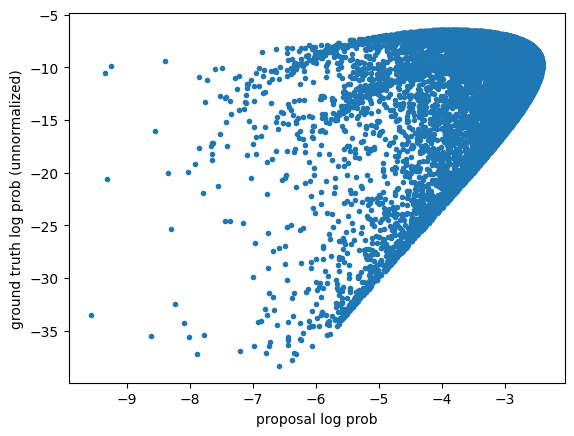

In [3]:
log_probs_inferred = posterior.log_prob(theta_inferred)  # log probs of proposal
log_probs_gt = log_prob_fn(theta_inferred, observation)  # gt log probs (unnormalized)

plt.plot(log_probs_inferred, log_probs_gt, '.')
plt.xlabel("proposal log prob")
plt.ylabel("ground truth log prob (unnormalized)");

Based on these densities, we can now compute the importance weights.

Effective sample size: 1466
Sample efficiency: 14.7%


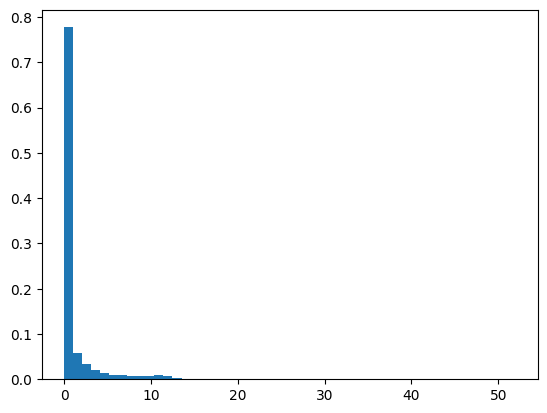

In [4]:
w = torch.exp(log_probs_gt - log_probs_inferred)  # importance weights
w = w / torch.mean(w)  # self-normalized importance sampling: normalize weights to mean 1
ESS = torch.sum(w)**2 / torch.sum(w**2)
sample_efficiency = ESS / len(w)

print(f"Effective sample size: {ESS:.0f}")
print(f"Sample efficiency: {100 * sample_efficiency:.1f}%")

plt.hist(w, density=True, bins=50);

With these importance weights, we can correct the inferred samples.

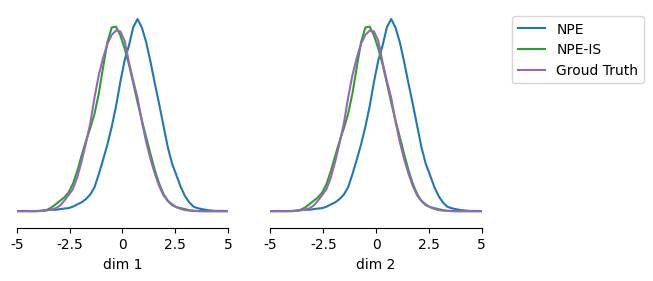

In [5]:
# get weighted samples
theta_inferred_is = theta_inferred[torch.where(w > torch.rand(len(w)) * torch.max(w))]
# *Note*: we here perform rejection sampling, as the plotting function
# used below does not support weighted samples. In general, with rejection
# sampling the number of samples will be smaller than the effective sample
# size unless we allow for duplicate samples.

# gt samples
gt_samples = MultivariateNormal(observation, eye(2)).sample((len(theta_inferred) * 5,))
gt_samples = gt_samples[prior.support.check(gt_samples)][:len(theta_inferred)]

# plot
fig, ax = marginal_plot(
    [theta_inferred, theta_inferred_is, gt_samples],
    limits=[[-5, 5], [-5, 5]],
    figsize=(6, 3),
    diag="kde",  # smooth histogram
)
ax[1].legend(["NPE", "NPE-IS", "Groud Truth"], loc="upper right",
                bbox_to_anchor=[1.8, 1.0, 0.0, 0.0]);

Indeed, the importance-sampled posterior matches the ground truth well, despite significant deviations of the initial NPE estimate.

### Importance sampling with the SBI toolbox

With the SBI toolbox, importance sampling is a one-liner. SBI supports two methods for importance sampling:
- `"importance"`: returns `n_samples` weighted samples (as above) corresponding to `n_samples * sample_efficiency` samples from the posterior. This results in unbiased samples, but the number of effective samples may be small when the SBI estimate is inaccurate.
- `"sir"` (sampling-importance-resampling): performs rejection sampling on a batched basis with batch size `oversampling_factor`.  This is a guaranteed way to obtain `N / oversampling_factor` samples, but these may be biased as the weight normalization is not performed across the entire set of samples.

In [6]:
posterior_sir = ImportanceSamplingPosterior(
    potential_fn=log_prob_fn,
    proposal=posterior,
    method="sir",
).set_default_x(observation)
theta_inferred_sir_2 = posterior_sir.sample((len(theta_inferred),), show_progress_bars=False,
                                            oversampling_factor=1)
theta_inferred_sir_32 = posterior_sir.sample((len(theta_inferred),),
                                             oversampling_factor=32, show_progress_bars=False)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

In [7]:
theta_inferred_sir_2.shape

torch.Size([10000, 2])

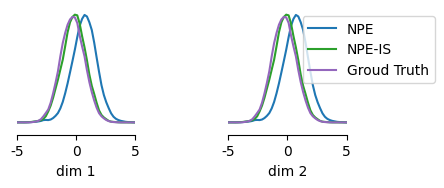

In [8]:
fig, ax = marginal_plot(
    [theta_inferred_sir_2, theta_inferred_sir_32, gt_samples],
    limits=[[-5, 5], [-5, 5]],
    figsize=(5, 1.5),
    diag="kde",  # smooth histogram
)
ax[1].legend(["NPE", "NPE-IS", "Groud Truth"], loc="upper right", bbox_to_anchor=[1.8, 1.0, 0.0, 0.0]);

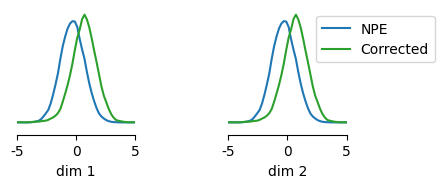

In [9]:
fig, ax = marginal_plot(
    [gt_samples, theta_inferred],
    limits=[[-5, 5], [-5, 5]],
    figsize=(5, 1.5),
    diag="kde",  # smooth histogram
)
ax[1].legend(["NPE", "Corrected"], loc="upper right",
                bbox_to_anchor=[1.8, 1.0, 0.0, 0.0]);

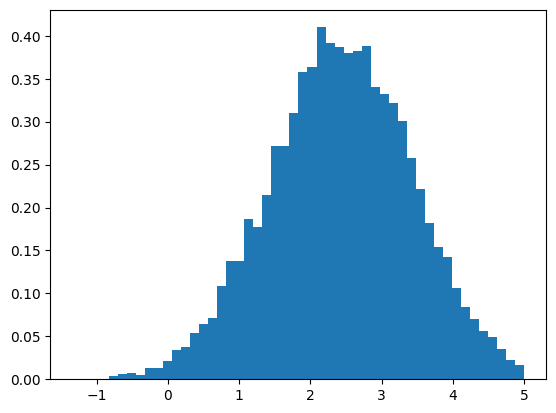

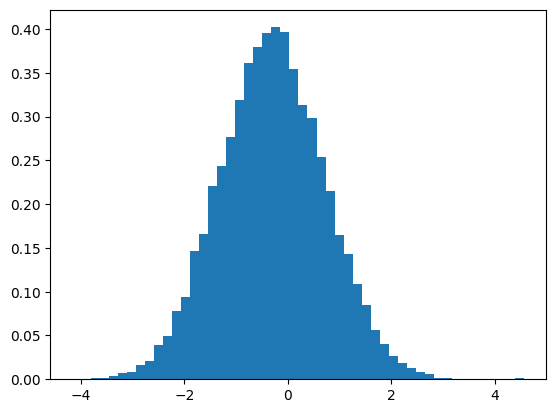

In [10]:
# gt samples
gt_samples = MultivariateNormal(observation, eye(2)).sample((len(theta_inferred) * 5,))
gt_samples = gt_samples[prior.support.check(gt_samples)][:len(theta_inferred)]

kwargs = dict(density=True, bins=50)
for idx_param in range(2):
    plt.hist(gt_samples[:, idx_param], **kwargs)
    plt.show()

_ = torch.manual_seed(3)
theta = prior.sample((50,))
x = sim.sample(theta)

_ = torch.manual_seed(4)
inference = SNPE(prior=prior)
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

_ = torch.manual_seed(2)
theta_gt = prior.sample((5,))
observations = sim.sample(theta_gt)
print("observations.shape", observations.shape)


oversampling_factor = 128  # higher will be slower but more accurate
n_samples = 5000

non_corrected_samples_for_all_observations = []
corrected_samples_for_all_observations = []
true_samples = []
for obs in observations:
    non_corrected_samples_for_all_observations.append(posterior.set_default_x(obs).sample((n_samples,)))
    corrected_posterior = ImportanceSamplingPosterior(
        potential_fn=Potential(prior=None, x_o=obs),
        proposal=posterior.set_default_x(obs),
        method="sir",
    )
    corrected_samples = corrected_posterior.sample((n_samples,), oversampling_factor=oversampling_factor)
    corrected_samples_for_all_observations.append(corrected_samples)

    gt_samples = MultivariateNormal(obs, eye(2)).sample((n_samples * 5,))
    gt_samples = gt_samples[prior.support.check(gt_samples)][:n_samples]
    true_samples.append(gt_samples)


for i in range(len(observations)):
    fig, ax = marginal_plot(
        [non_corrected_samples_for_all_observations[i], corrected_samples_for_all_observations[i], true_samples[i]], 
        limits=[[-5, 5], [-5, 5]], 
        points=theta_gt[i], 
        figsize=(5, 1.5),
        diag="kde",  # smooth histogram
    )
    ax[0][1].legend(["NPE", "Corrected", "Ground truth"], loc="upper right", bbox_to_anchor=[1.8, 1.0, 0.0, 0.0])

 Neural network successfully converged after 93 epochs.observations.shape torch.Size([5, 2])


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 1024 posterior samples:   0%|          | 0/1024 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 1024 posterior samples:   0%|          | 0/1024 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 1024 posterior samples:   0%|          | 0/1024 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 1024 posterior samples:   0%|          | 0/1024 [00:00<?, ?it/s]

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 1024 posterior samples:   0%|          | 0/1024 [00:00<?, ?it/s]

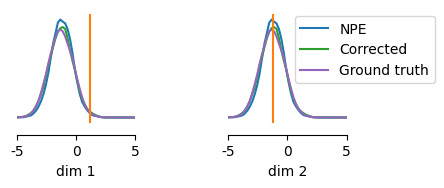

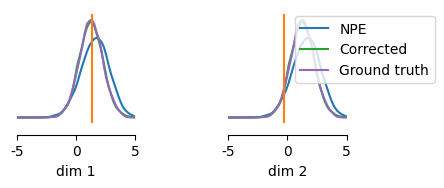

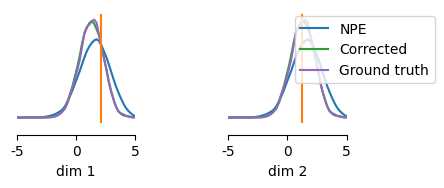

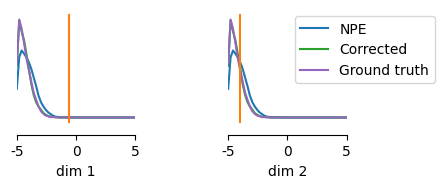

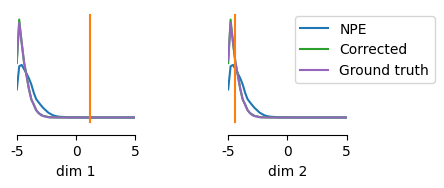

In [11]:
class Simulator:
    def __init__(self):
        pass

    def log_prob(self, theta, x):
        return MultivariateNormal(theta, eye(2)).log_prob(x) + prior.log_prob(theta)

    def sample(self, theta):
        return theta + torch.randn((theta.shape))


class Potential(BasePotential):
    allow_iid_x = False

    def __init__(self, prior, x_o, **kwargs):
        super().__init__(prior, x_o, **kwargs)

    def __call__(self, theta, **kwargs):
        return sim.log_prob(theta, self.x_o)


prior = BoxUniform(-5 * ones((2,)), 5 * ones((2,)))
sim = Simulator()

_ = torch.manual_seed(3)
theta = prior.sample((50,))
x = sim.sample(theta)

_ = torch.manual_seed(4)
inference = SNPE(prior=prior)
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

_ = torch.manual_seed(2)
theta_gt = prior.sample((5,))
observations = sim.sample(theta_gt)
print("observations.shape", observations.shape)


oversampling_factor = 128  # higher will be slower but more accurate
n_samples = 5000

non_corrected_samples_for_all_observations = []
corrected_samples_for_all_observations = []
true_samples = []
for obs in observations:
    non_corrected_samples_for_all_observations.append(posterior.set_default_x(obs).sample((n_samples,)))
    corrected_posterior = ImportanceSamplingPosterior(
        potential_fn=Potential(prior=None, x_o=obs),
        proposal=posterior.set_default_x(obs),
        method="sir",
    )
    corrected_samples = corrected_posterior.sample((n_samples,),
                                                   oversampling_factor=oversampling_factor)
    corrected_samples_for_all_observations.append(corrected_samples)

    gt_samples = MultivariateNormal(obs, eye(2)).sample((n_samples * 5,))
    gt_samples = gt_samples[prior.support.check(gt_samples)][:n_samples]
    true_samples.append(gt_samples)


for i in range(len(observations)):
    fig, ax = marginal_plot(
        [non_corrected_samples_for_all_observations[i],
         corrected_samples_for_all_observations[i],
         true_samples[i]],
        limits=[[-5, 5], [-5, 5]],
        points=theta_gt[i],
        figsize=(5, 1.5),
        diag="kde",  # smooth histogram
    )
    ax[1].legend(["NPE", "Corrected", "Ground truth"], loc="upper right", bbox_to_anchor=[1.8, 1.0, 0.0, 0.0])

In [12]:
non_corrected_samples_for_all_observations.append(posterior.set_default_x(obs).sample((n_samples,)))
corrected_posterior = ImportanceSamplingPosterior(
    potential_fn=Potential(prior=None, x_o=obs),
    proposal=posterior.set_default_x(obs),
    method="sir",
)
corrected_samples = corrected_posterior.sample((n_samples,), oversampling_factor=oversampling_factor)
corrected_samples_for_all_observations.append(corrected_samples)

gt_samples = MultivariateNormal(obs, eye(2)).sample((n_samples * 5,))
gt_samples = gt_samples[prior.support.check(gt_samples)][:n_samples]
true_samples.append(gt_samples)

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 9984 posterior samples:   0%|          | 0/9984 [00:00<?, ?it/s]

Drawing 1024 posterior samples:   0%|          | 0/1024 [00:00<?, ?it/s]